In [1]:
import pandas as pd
import numpy as np

1. Import confirmed, recovered and deaths data set for a given country

In [169]:
confirmed = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recovered = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
deaths = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

2. Pre-process the datasets

In [170]:
def reformat(df, country, col_name):
    
    df = df[df['Country/Region'] == country]
    index = df.iloc[0].name

    df = df.T
    df = df.rename({index: col_name}, axis = 1)
    # get rid of columns that do not represent the number of recovered/confirmed/deaths 
    df = df.iloc[4:,:]
    
    return df

    #df = df[df[col_name] > 0]


In [171]:
recovered = reformat(recovered, 'Italy', 'Recovered cases')
confirmed = reformat(confirmed, 'Italy', 'Confirmed cases')
deaths = reformat(deaths, 'Italy', 'Deaths cases')

recovered.head()

,Recovered cases
1/22/20,0
1/23/20,0
1/24/20,0
1/25/20,0
1/26/20,0


3. Create new data frame recovered per day so we know how many people recovered from the epidemic on a given day


**problem** : Here, I see that recovered_daily contains a negative value, therefore recovered is not fully incremental. ??? Change dataset?

In [172]:
recovered_daily = recovered.diff()
recovered_daily.iloc[0,:] = 0

In [173]:
deaths_daily = deaths.diff()
deaths_daily.iloc[0] = 0

4. Generate dataset infected representing the number of infected individuals at a given time t (not the new number of infected, number of actively infected individuals)

$$\text{confirmed}(t)=\text{confirmed}(t)-\sum_{i=\text{day}_0}^{t}\text{recovered_daily(i)}-\sum_{i=\text{day}_0}^{t}\text{deaths_daily}(i)$$

In [174]:
infected_ = []
days_ = []
# i: date (time t)
# row: row
acc_deaths = 0
acc_recovered = 0

for i, row in confirmed.iterrows():
    acc_recovered += recovered_daily.loc[i]['Recovered cases']
    acc_deaths += deaths_daily.loc[i]['Deaths cases']
    
    diff = row['Confirmed cases'] - acc_recovered - acc_deaths
    
    infected_.append(diff)
    days_.append(i)

Careful, infected represents active number of infected, not new number of infected

In [175]:
infected = pd.DataFrame({'Date': days_,'Infected Cases': infected_})

In [176]:
recovered = recovered.reset_index().rename({'index':'Date'}, axis = 1)

Now we can start working on predicting our gammas. 
Recovered is cumulative, as expected (absorbing state in our SIR model) and infected represents the number of infected individual at a certain date

In [177]:
data = recovered.merge(infected, on='Date')

In [178]:
data['Date'] = pd.to_datetime(data['Date'])
#df['DOB'] = pd.to_datetime(df.DOB)


In [179]:
dataframe = pd.concat([data['Date'],data['Recovered cases'], data['Infected Cases'].shift(7),
                   data['Infected Cases'].shift(8),data['Infected Cases'].shift(9),
                   data['Infected Cases'].shift(10),data['Infected Cases'].shift(11),
                   data['Infected Cases'].shift(12),data['Infected Cases'].shift(13),
                   data['Infected Cases'].shift(14),data['Infected Cases'].shift(15),
                   data['Infected Cases'].shift(16),data['Infected Cases'].shift(17),
                   data['Infected Cases'].shift(18),data['Infected Cases'].shift(19),
                   data['Infected Cases'].shift(20),data['Infected Cases'].shift(21)], axis=1)

To go on I think it would be better to have a larger data set

In [180]:
# create lagged dataset
dataframe.columns = ['Date', 'Recovered cases', 'Infected cases t-7','Infected cases t-8','Infected cases t-9',
                    'Infected cases t-10','Infected cases t-11','Infected cases t-12','Infected cases t-13',
                    'Infected cases t-14','Infected cases t-15','Infected cases t-16','Infected cases t-17',
                    'Infected cases t-18','Infected cases t-19','Infected cases t-20','Infected cases t-21']

# Keep data such that we have value t-21 at any given day t
dataframe = dataframe[~np.isnan(dataframe['Infected cases t-21'])]



In [181]:
dataframe = dataframe.set_index('Date')

### Generate unsupervised data set (unused)

Take $t-7$ as the last date in our dataset. Therefore, dates from $t-21$ to $t-7$ exist. Date $t$ is a date in the future. This means that $R(t)$ is a value that we do not know yet. So, for $t-7=\text{today}$ to $t=\text{today}+7\text{ days}$, we will keep values $I(t-7)$ to $I(t)$ as features for unlabeled data. 

In [15]:
from datetime import datetime
from datetime import timedelta

#Select last date on our dataframe
#t0 is the last date at which we have a label. for t>t0, we de not have R(t), as t is in the future
# for t0 <= t <= t0+7, the value I(t-7) to I(t-21) exist.

t0 = dataframe.index[-1]
#t0 = datetime.strptime(t0,'%m/%d/%y')

#t7 = t0 + timedelta(days=7)

#the first date needs to be the next date after the last one at which we have a label
t0 += timedelta(days = 1)


In [16]:
#Same as labeled df, however without the number of recovered cases
unsupervised_df = pd.DataFrame(columns=[['Date', 'Infected cases t-7','Infected cases t-8','Infected cases t-9',
                    'Infected cases t-10','Infected cases t-11','Infected cases t-12','Infected cases t-13',
                    'Infected cases t-14','Infected cases t-15','Infected cases t-16','Infected cases t-17',
                    'Infected cases t-18','Infected cases t-19','Infected cases t-20','Infected cases t-21']])

In [17]:
for single_date in (t0 + timedelta(n) for n in range(7)):
    
    list_of_infected_per_delta = []
    list_of_infected_per_delta.append(single_date)
    
    #for each day t in the span on our week, append I(t-7) ... I(t-21) to list_of_infected_per_delta
    # this list will be a row to our new dataframe
    for delta_t in range(7,22):
        list_of_infected_per_delta.append(data[data['Date'] == single_date - timedelta(days = delta_t)]['Infected Cases'].iloc[0])
    
    print(list_of_infected_per_delta)
    unsupervised_df.loc[len(unsupervised_df)] = list_of_infected_per_delta

    #unsupervised_df = unsupervised_df.append(list_of_infected_per_delta)

[Timestamp('2020-04-11 00:00:00'), 88274, 85388, 83049, 80572, 77635, 75528, 73880, 70065, 66414, 62013, 57521, 54030, 50826, 46638, 42681]
[Timestamp('2020-04-12 00:00:00'), 91246, 88274, 85388, 83049, 80572, 77635, 75528, 73880, 70065, 66414, 62013, 57521, 54030, 50826, 46638]
[Timestamp('2020-04-13 00:00:00'), 93187, 91246, 88274, 85388, 83049, 80572, 77635, 75528, 73880, 70065, 66414, 62013, 57521, 54030, 50826]
[Timestamp('2020-04-14 00:00:00'), 94067, 93187, 91246, 88274, 85388, 83049, 80572, 77635, 75528, 73880, 70065, 66414, 62013, 57521, 54030]
[Timestamp('2020-04-15 00:00:00'), 95262, 94067, 93187, 91246, 88274, 85388, 83049, 80572, 77635, 75528, 73880, 70065, 66414, 62013, 57521]
[Timestamp('2020-04-16 00:00:00'), 96877, 95262, 94067, 93187, 91246, 88274, 85388, 83049, 80572, 77635, 75528, 73880, 70065, 66414, 62013]
[Timestamp('2020-04-17 00:00:00'), 98273, 96877, 95262, 94067, 93187, 91246, 88274, 85388, 83049, 80572, 77635, 75528, 73880, 70065, 66414]


In [18]:
unsupervised_df

,Date,Infected cases t-7,Infected cases t-8,Infected cases t-9,Infected cases t-10,Infected cases t-11,Infected cases t-12,Infected cases t-13,Infected cases t-14,Infected cases t-15,Infected cases t-16,Infected cases t-17,Infected cases t-18,Infected cases t-19,Infected cases t-20,Infected cases t-21
0,2020-04-11,88274,85388,83049,80572,77635,75528,73880,70065,66414,62013,57521,54030,50826,46638,42681
1,2020-04-12,91246,88274,85388,83049,80572,77635,75528,73880,70065,66414,62013,57521,54030,50826,46638
2,2020-04-13,93187,91246,88274,85388,83049,80572,77635,75528,73880,70065,66414,62013,57521,54030,50826
3,2020-04-14,94067,93187,91246,88274,85388,83049,80572,77635,75528,73880,70065,66414,62013,57521,54030
4,2020-04-15,95262,94067,93187,91246,88274,85388,83049,80572,77635,75528,73880,70065,66414,62013,57521
5,2020-04-16,96877,95262,94067,93187,91246,88274,85388,83049,80572,77635,75528,73880,70065,66414,62013
6,2020-04-17,98273,96877,95262,94067,93187,91246,88274,85388,83049,80572,77635,75528,73880,70065,66414


### Persistence model

In [25]:
y = dataframe.values[:,0]
X = dataframe.values[:,1:]

In [26]:
# split into train and test sets
train, test = X[:len(X)-10], X[len(X)-10:]
train_y, train_X = train[:,0], train[:,1:]
test_y, test_X = test[:,0], test[:,1:]

One of the simplest methods for predicting the future behavior of a time series is the so-called persistence model. Persistence implies that future values of the time series are calculated on the assumption that conditions remain unchanged between “current” time  and future time $t + T_H$. For a stationary time series—one whose mean and variance do not change over time—a straightforward implementation of the persistence model is simply

$$\hat{y}(t+T_H) = y(t)$$

which may be referred as “dull persistence.”

Test MSE: 732527695.788


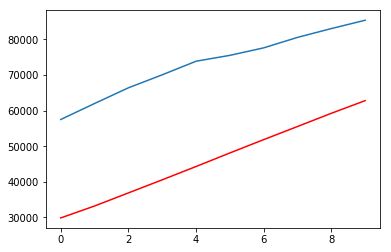

In [28]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

def model_persistence(x):
    return x
 
# walk-forward validation
predictions = list()
for x in test_X:
    # I added a slight change, by using the mean of the 14 observations in order to have one dimension input to the
    # persistence model
    yhat = model_persistence(np.mean(x))
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

The expected number of recovered individuals for the next ten days are plotted (blue) compared to the predictions from the model (red).

In [526]:
# if we try to predict the next seven days we have MSE Test MSE: 193348.358
# if we try to predict the next ten days we have MSE Test MSE: 143632.721

#  Linear regression model

In [182]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

If we take out the first 15 days due to noise, unstability of covid-19 progress

In [183]:
dataframe_new = dataframe.iloc[15:,:].copy()

In [184]:
y = dataframe_new['Recovered cases'].values
X = dataframe_new.iloc[:,1:].values

In [186]:
dataframe.loc[:,'Recovered cases'] = dataframe_new.loc[:,'Recovered cases'].apply(pd.to_numeric)


In [187]:
dataframe_new['Recovered cases'] = dataframe_new['Recovered cases'].apply(pd.to_numeric)


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


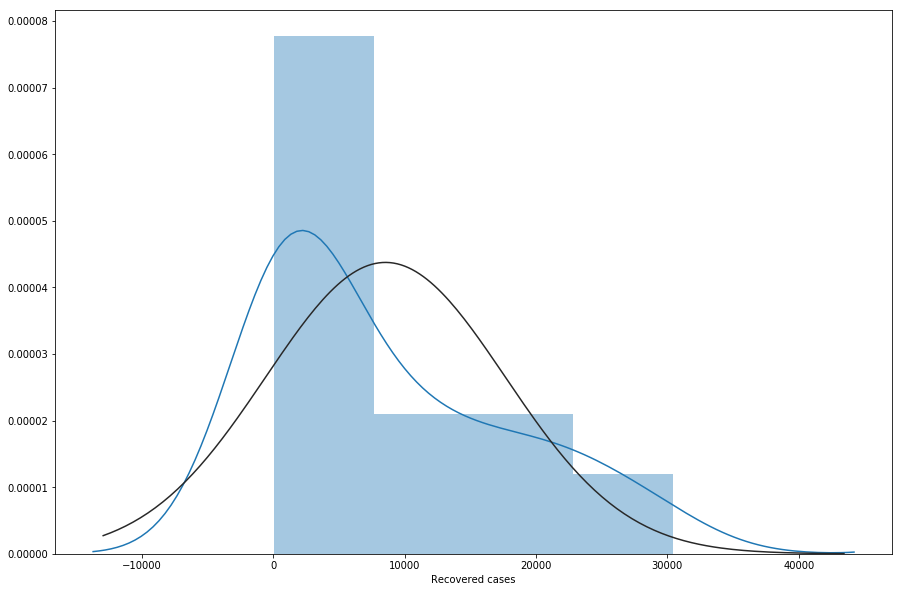

In [188]:
from scipy.stats import norm

plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(dataframe_new['Recovered cases'], fit=norm)

In [191]:
# split into train and test sets

pct_90 = int(np.ceil(90*len(X)/100))

print(pct_90)

#predict las 10%

train, test = dataframe_new.values[:pct_90], dataframe_new.values[pct_90:]
y_train, X_train = train[:,0], train[:,1:]
y_test, X_test = test[:,0], test[:,1:]

40


In [192]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [193]:
regressor = LinearRegression(normalize=True)  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [194]:
y_pred = regressor.predict(X_test)


In [195]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
0,24392.0,25135.294924
1,26491.0,28148.190732
2,28470.0,30846.493963
3,30455.0,32390.945776


In [196]:
print('Mean Absolute Error:',  "%.2f" % (metrics.mean_absolute_error(y_test, y_pred),))  
print('Mean Squared Error:', "%.2f" % (metrics.mean_squared_error(y_test, y_pred),) )  
print('Root Mean Squared Error:', "%.2f" % (np.sqrt(metrics.mean_squared_error(y_test, y_pred),)))

Mean Absolute Error: 1678.23
Mean Squared Error: 3173594.52
Root Mean Squared Error: 1781.46


In [197]:
regressor.coef_

array([ 2.39409765e-01,  3.79037366e-01, -1.22527853e-01, -1.00420676e-01,
        2.49715461e-01, -9.54644043e-02, -4.10800809e-01, -4.97027829e-01,
        8.60260974e-03, -9.55686903e-03,  1.95494393e-04,  8.81584554e-02,
        5.55152603e-01,  4.20262125e-01, -9.59310982e-03])

In [198]:
print("R^2 Score: ","%.3f" % (regressor.score(X_test, y_test),) )

R^2 Score:  0.376


In [200]:
coeff_df = pd.DataFrame(regressor.coef_, dataframe.iloc[:,1:].columns, columns=['Coefficient'])  
coeff_df

,Coefficient
Infected cases t-7,0.239410
Infected cases t-8,0.379037
Infected cases t-9,-0.122528
Infected cases t-10,-0.100421
Infected cases t-11,0.249715
Infected cases t-12,-0.095464
Infected cases t-13,-0.410801
Infected cases t-14,-0.497028
Infected cases t-15,0.008603
Infected cases t-16,-0.009557


### Plot coefficients (distribution of gamma)

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


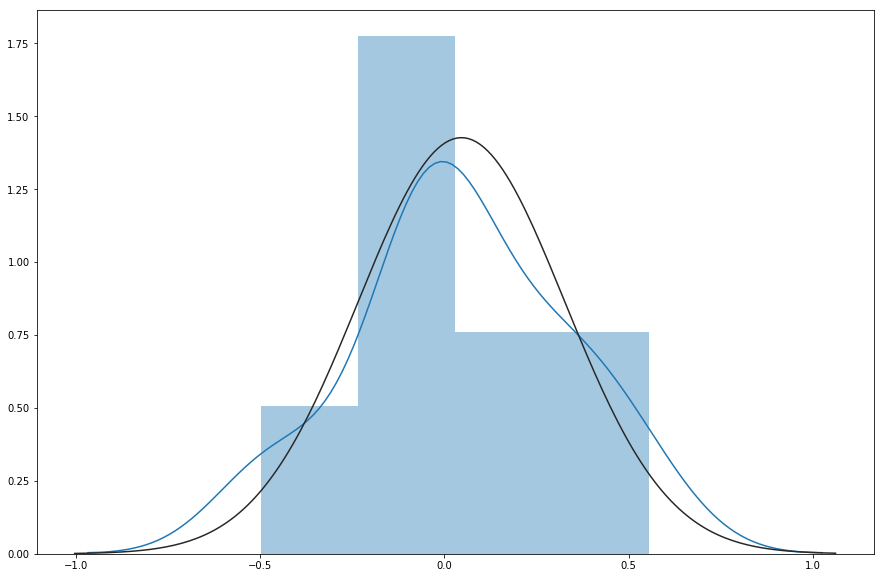

In [201]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(coeff_df, fit=norm)

**Update this**

For a unit increase in the number of recovered individuals at time t, that means there is:
- An increase of 21 infected at day t-20
- A decrease of 13 infected at day t-18

We see that the closer we are to the recovery date, the lower the number of infected cases has an impact on the number od recovered cases 

### Plot Actual values (y test) versus predicted values

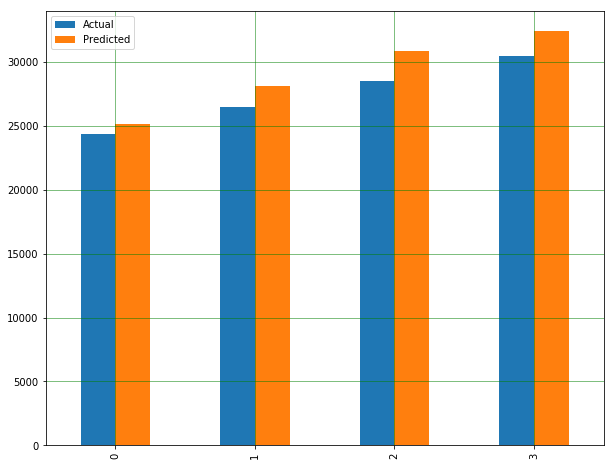

In [202]:
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

There are many factors that may have contributed to this inaccuracy, for example :

- **Need more data**: We need to have a huge amount of data to get the best possible prediction.
- **Bad assumptions**: We made the assumption that this data has a linear relationship, but that might not be the case. Visualizing the data may help us determine that.
- **Poor features**: The features we used may not have had a high enough correlation to the values we were trying to predict.

#  ridge regression (L2)

In [203]:
from sklearn.linear_model import Ridge
from sklearn import linear_model
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)


In [204]:
#y = dataframe_new['Recovered cases'].values
#X = dataframe_new.iloc[:,1:].values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# split into train and test sets

pct_90 = int(np.ceil(90*len(X)/100))

print(pct_90)

#predict las 10%

train, test = dataframe_new.values[:pct_90], dataframe_new.values[pct_90:]
y_train, X_train = train[:,0], train[:,1:]
y_test, X_test = test[:,0], test[:,1:]

40


In [207]:
# Create ridge regression with three possible alpha values

clf = Ridge(alpha=1, normalize=True)
# Fit the linear regression
model = clf.fit(X_train, y_train)

#y_pred = clf.predict(X_test)
y_pred = clf.predict(X_test)

In [208]:
clf.score(X_test, y_test)

0.6760816613466603

In [209]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1248.084655448818
Mean Squared Error: 1647242.496368333
Root Mean Squared Error: 1283.449452206176


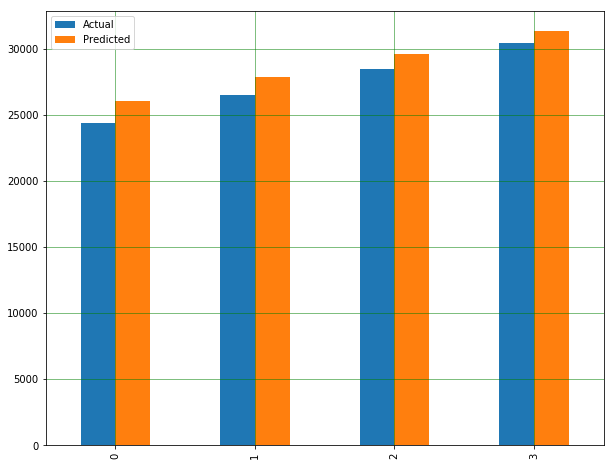

In [210]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

#  Lasso Regression (L1)

In [211]:
#y = dataframe_new['Recovered cases'].values
#X = dataframe_new.iloc[:,1:].values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# split into train and test sets

pct_90 = int(np.ceil(90*len(X)/100))

#predict las 10%

train, test = dataframe_new.values[:pct_90], dataframe_new.values[pct_90:]
y_train, X_train = train[:,0], train[:,1:]
y_test, X_test = test[:,0], test[:,1:]


clf = linear_model.Lasso(alpha=0.1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


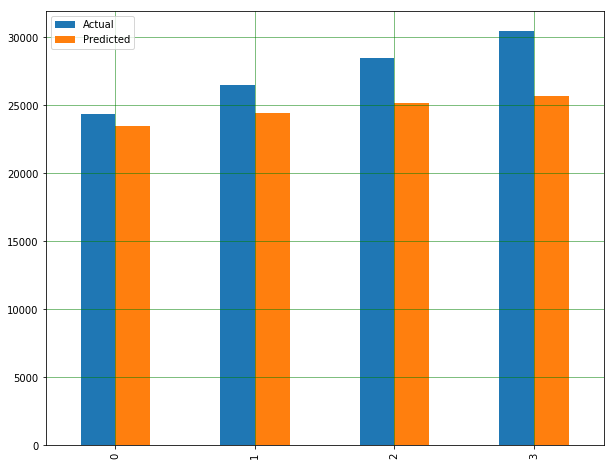

In [212]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()


In [213]:
clf.score(X_test, y_test)

-0.8986636622150304

# Linear Elastic Net regression 
(Linear regression with combined L1 and L2 priors as regularizer)

The elastic net method overcomes the limitations of the LASSO (least absolute shrinkage and selection operator) method which uses a penalty function based on

$$||\beta||_1=\sum_{j=1}^p{|\beta_j|}$$

The parameters for the elastic net method are defined by

$$\hat{\beta}\equiv \text{argmin}_{\beta}(||y-X\beta||^2+\lambda_2||\beta||^2+\lambda_1||\beta||_1)$$

In our case here, $\lambda_1=\lambda_2=\alpha$

In [214]:
y = dataframe_new['Recovered cases'].values
X = dataframe_new.iloc[:,1:].values

#-----#

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# split into train and test sets

pct_90 = int(np.ceil(90*len(X)/100))

#predict las 10%

train, test = X[:pct_90], X[pct_90:]
y_train, X_train = train[:,0], train[:,1:]
y_test, X_test = test[:,0], test[:,1:]


#-----#

clf = linear_model.ElasticNet(alpha=0.1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

40


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [216]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df


,Actual,Predicted
0,77635.0,77517.676165
1,80572.0,81218.651716
2,83049.0,84594.121602
3,85388.0,86353.384345


In [217]:
clf.score(X_test, y_test)

0.8870490095413568

In [218]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 818.6203743612787
Mean Squared Error: 937822.7553214013
Root Mean Squared Error: 968.4124923406355


In [221]:
coeff_df = pd.DataFrame(regressor.coef_, dataframe.iloc[:,1:].columns, columns=['Coefficient'])  
coeff_df

,Coefficient
Infected cases t-7,0.239410
Infected cases t-8,0.379037
Infected cases t-9,-0.122528
Infected cases t-10,-0.100421
Infected cases t-11,0.249715
Infected cases t-12,-0.095464
Infected cases t-13,-0.410801
Infected cases t-14,-0.497028
Infected cases t-15,0.008603
Infected cases t-16,-0.009557


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


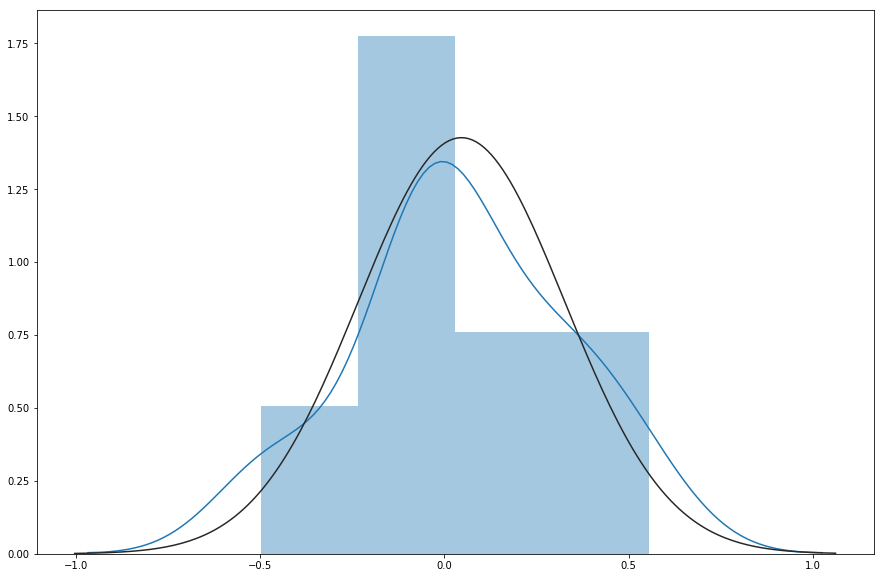

In [222]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(coeff_df, fit=norm)

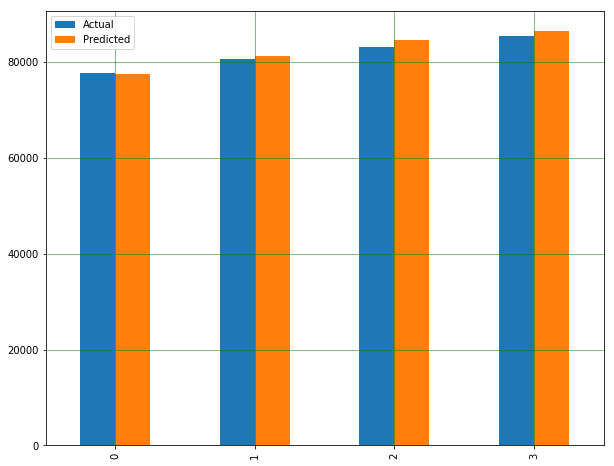

In [223]:
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Laplacian

### Labeled Data

In [429]:
dataframe_new = dataframe.iloc[15:,:]

In [430]:
yl = dataframe_new['Recovered cases'].values
Xl = dataframe_new.iloc[:,1:].values

### Unlabeled Data

In [438]:
Xu = unsupervised_df.iloc[:,1:].values

In [447]:
X = dataframe_new + unsupervised_df

In [451]:
unsupervised_df = unsupervised_df.set_index('Date')

In [460]:
one = pd.DataFrame(Xu)
two = pd.DataFrame(Xl)

In [464]:
X = pd.concat([two, one], axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

### Algorithm

In [440]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg,random
from sklearn.base import BaseEstimator
from sklearn import datasets,metrics

class LRRidge(BaseEstimator):
    def __init__(self,alpha=1.,beta=1.,gamma=10.,k=10):
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
        self.k=k

    def fit(self,Xl,yl,Xu):
        self.X=np.r_[Xl,Xu]
        #self.X=self.X[random.permutation(len(self.X))]
        self.X2=np.c_[np.sum(self.X**2,1)]
        Xl2=np.c_[np.sum(Xl**2,1)]
        Xu2=np.c_[np.sum(Xu**2,1)]
        Phil=np.exp(-self.gamma*(Xl2+self.X2.T-2*Xl.dot(self.X.T)))
        Phiu=np.exp(-self.gamma*(Xu2+self.X2.T-2*Xu.dot(self.X.T)))

        Phiu2=np.c_[np.sum(Phiu**2,1)]
        d=Phiu2+Phiu2.T-2*Phiu.dot(Phiu.T)
        p=np.c_[np.sort(d,axis=1)[:,self.k+1]]
        W=d<=p
        W=(W+W.T)!=0
        D=np.diag(np.sum(W,axis=1))
        L=D-W
        
        n_features=Phil.shape[1]
        self.theta=linalg.pinv(Phil.T.dot(Phil)+self.alpha*np.identity(n_features)+self.beta*Phiu.T.dot(L).dot(Phiu)).dot(Phil.T).dot(yl)

        return self

    def predict(self,X):
        X2=np.c_[np.sum(X**2,1)]
        Phi=np.exp(-self.gamma*(X2+self.X2.T-2*X.dot(self.X.T)))
        return (Phi.dot(self.theta)>=0)*2-1



In [446]:
Xu + Xl

ValueError: operands could not be broadcast together with shapes (14,15) (44,15) 

In [443]:
Xl.shape

(44, 15)

### Implementation

In [469]:
clf=LRRidge().fit(Xl,yl,Xu)
ypred=clf.predict(X)
yupred=clf.predict(Xu)

print("Accuracy (LRRidge):" + metrics.accuracy_score(yu,yupred))

from sklearn.linear_model import RidgeClassifierCV
gamma=10.
X2=np.c_[np.sum(X**2,1)]
Phi=np.exp(-gamma*(X2+X2.T-2*X.dot(X.T)))
clf=RidgeClassifierCV().fit(Phi[il],yl)
yupred2=clf.predict(Phi[iu])
print("Accuracy (Ridge):" + metrics.accuracy_score(yu,yupred2))

colors=np.array(["r","b"])
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(Xu[:,0],Xu[:,1],c="w",s=20)
plt.scatter(Xl[:,0],Xl[:,1],color=colors[(1+yl)/2],s=100)
plt.subplot(122)
plt.scatter(X[:,0],X[:,1],color=colors[(1+ypred)/2])
plt.tight_layout()
plt.show()


TypeError: loop of ufunc does not support argument 0 of type float which has no callable exp method

- try log values
- didn't try laplacian bc w ridge parameters achieve gaussian distribution which is what we want